# Retrieve and download the raw Youtube video

In [2]:
from pytubefix import YouTube
from pathlib import Path
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
video_link = "https://www.youtube.com/watch?v=45KmZUc0CzA"
data_folder = "../data"


yt_item = YouTube(video_link)
print(yt_item.title)

video_path = f"{data_folder}/raw/{yt_item.title}.mp4"

stream = yt_item.streams.get_highest_resolution()
if not (path := Path(video_path)).exists():
    stream.download(output_path=path.parent, filename=path.name)

codec = stream.codecs[0]
print(codec)
fps = stream.fps
print(fps)
height, width = stream.width, stream.height
print(height, width)

Janja Garnbret Goes Gold at Paris 2024 🥇 👑 | Full Replay all climbs
avc1.42001E
25
640 360


# Capture highlight moments from the video

## Naive and personal annotation
My first instinct is to try and select moments from the video that I personally consider as highlight moments, and then try to figure out which aspects from the video can be used to automate the process.

Here follows the video highlight moments timestamps:

Janja Garnbret Goes Gold at Paris 2024 🥇 👑 | Full Replay all climbs
* 0:59 - 1:07
* 1:26 - 1:35
* 2:30 - 2:45
* 2:52 - 3:00
* 4:42 - 5:17
* 7:04 - 7:34

Specific Olympic Games transisions (Fade-in = FI // Fade-out)
* 0:58-0:59 (FI)
* 1:06-1:07
* 2:51-2:52 (FI)
* 3:00-3:01
* 4:42-4:43 (FI)
* 5:16:5-17

## Observations 

For this particular video, the video edits could be a great clue, as the olympic rings appear during transitions before and after a replay. There is also a specific sound at the beginning of the replay, when the olympic rings appear on the screen. It is important to note that this solution would not generalize well with any other video.

A more generalizable solution would be to detect when a single person is being the subject of the frame; we would expect these frames to "matter more" and, if there are enough consecutive frames, it would constitute a highlight moment.

Another general solution related to bouldering is the use of pose estimation, and to find a way to detect rapid changes in poses. This idea would enhance the person detection idea. The issue is how to determine what a "rapid change in poses" actually means.

Crowd noise could be an indicator of the relevance of a moment during the video, but this is hard to isolate from the commentators, and I feel that crowd noise was tuned down in the video.

---

Before going toward coding, I will rate the ideas on specific criterions to help me decide which solution to go to.

| Idea | Ease to Develop | Generalization to Other Videos | Expected Relevance |
|------|------------------|-------------------------------|--------------------|
| Olympic Rings (Sound is optional) | +++ | + | +++ |
| Single Person Detection | +++ | +++ | ++ |
| Pose Estimation and Rapid Changes | + | +++ | +++ |
| Crowd Noise Analysis | + | + | ++ |

Considering the project timeline, I will develop the most easy solutions which are the Olympic Rings (visually, and optionally with the sound approach), as well as the Single Person Detection.

# Olympic Rings and Sound

## Olympic Rings video transition detection

My first intuition when trying to detect the video transitions is to try and find classic DL Computer Vision techniques. 
Let's first set the fade-in and fade-out video sequences timestamps, and make a function to extract these video sequences.


In [5]:
import cv2
from datetime import time
from loguru import logger
import clip
from PIL import Image

In [5]:
# Define fade-in and fade-out timestamps and durations
fade_in_timestamps = [
    time(minute=0, second=58, microsecond=800000),
    time(minute=2, second=51, microsecond=250000),
    time(minute=4, second=42, microsecond=400000),
]
fade_in_duration = time(second=1, microsecond=0)

fade_out_timestamps = [
    time(minute=1, second=6, microsecond=500000),
    time(minute=3, second=0, microsecond=300000),
    time(minute=5, second=16, microsecond=750000),
]
fade_out_duration = time(second=1, microsecond=0)

In [6]:
def retrieve_video_sequence_from_timestamps(cap: cv2.VideoCapture, start_time: time, duration: time):
    """Given a video capture object, start time, and duration, retrieves the corresponding video frames."""

    start_frame = ((start_time.microsecond / 1e6) + start_time.second + start_time.minute * 60) * fps    # fps is defined globally from the stream metadata
    end_frame = ((duration.microsecond / 1e6) + duration.second + duration.minute * 60) * fps + start_frame
    
    frames = []
    for frame_num in range(int(start_frame), int(end_frame)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            logger.warning(f"Could not read frame {frame_num}. Stopping retrieval.")
            break
        frames.append(frame)
    
    return frames


def write_video_sequence(frames, output_path: str, fps: float):
    """Writes a sequence of video frames to a video file.
    Note: output video is saved in .mp4 format using the 'mp4v' codec."""
    if not frames:
        logger.warning("No frames to write.")
        return
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Using 'mp4v' codec for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (height, width)) # width and height are defined globally from the stream metadata
    
    for frame in frames:
        out.write(frame)
    
    out.release()

In [7]:
def extract_fade_in_out_sequences(video_path: str) -> tuple[list, list]:
    """Extracts fade-in and fade-out sequences from the video based on predefined timestamps."""

    assert Path(video_path).is_file(), f"Video file {video_path} does not exist."

    cap = cv2.VideoCapture(video_path)

    fade_in_sequences = []
    for timestamp in fade_in_timestamps:
        sequence = retrieve_video_sequence_from_timestamps(cap, timestamp, fade_in_duration)
        print(f"Writing fade-in sequence for timestamp {timestamp} with {len(sequence)} frames.")
        write_video_sequence(sequence, f"{data_folder}/sequences/fade_in_{timestamp.minute}_{timestamp.second}.mp4", fps) # fps is defined globally from the stream metadata
        fade_in_sequences.append(sequence)
    
    fade_out_sequences = []
    for timestamp in fade_out_timestamps:
        sequence = retrieve_video_sequence_from_timestamps(cap, timestamp, fade_out_duration)
        print(f"Writing fade-out sequence for timestamp {timestamp} with {len(sequence)} frames.")
        write_video_sequence(sequence, f"{data_folder}/sequences/fade_out_{timestamp.minute}_{timestamp.second}.mp4", fps)  # fps is defined globally from the stream metadata
        fade_out_sequences.append(sequence)
    
    cap.release()

    return fade_in_sequences, fade_out_sequences

fade_in_sequences, fade_out_sequences = extract_fade_in_out_sequences(video_path)

Writing fade-in sequence for timestamp 00:00:58.800000 with 25 frames.
Writing fade-in sequence for timestamp 00:02:51.250000 with 25 frames.
Writing fade-in sequence for timestamp 00:04:42.400000 with 25 frames.
Writing fade-out sequence for timestamp 00:01:06.500000 with 25 frames.
Writing fade-out sequence for timestamp 00:03:00.300000 with 25 frames.
Writing fade-out sequence for timestamp 00:05:16.750000 with 25 frames.


Now that we have the sequences, let's embed them and compare them together. This will tell us how "alike" the sequences are, and help us decide a threshold to recognize the sequence.

Then, we can then process all video frames and compare them to the mean of the sequences embeddings, and see if the sequences are correctly recognized.

In [8]:
def embed_video_sequence(frames, model, preprocess, device):
    """Embed the video sequence using a pre-trained model (e.g., CLIP, TimeSformer)."""

    sequence_input = [ preprocess(Image.fromarray(frame)).to(device) for frame in frames ]
    sequence_input = torch.stack(sequence_input)  # Stack frames into a batch tensor

    with torch.no_grad():
        frames_features =  model.encode_image(sequence_input) # Handle batch processing

    return frames_features

# Load model
model, preprocess = clip.load("ViT-B/32", device=device)

fade_in_sequences_embeddings = [embed_video_sequence(seq, model, preprocess, device) for seq in fade_in_sequences]
fade_out_sequences_embeddings = [embed_video_sequence(seq, model, preprocess, device) for seq in fade_out_sequences]

In [9]:
def cosine_similarity(embeddings1, embeddings2):
    """Compute cosine similarity between two sets of embeddings."""
    similarity = torch.nn.CosineSimilarity(dim=1)(embeddings1, embeddings2)
    return similarity

# Compare fade-in embeddings between each other
for frame_idx, fade_in_emb in enumerate(fade_in_sequences_embeddings):
    for j, fade_in_emb2 in enumerate(fade_in_sequences_embeddings):
        similarity = cosine_similarity(fade_in_emb, fade_in_emb2)
        print(f"Similarity between fade-in sequence {frame_idx} and fade-in sequence {j}: {similarity.mean().item()}")

print("\n")

# Compare fade-out embeddings between each other
for frame_idx, fade_out_emb in enumerate(fade_out_sequences_embeddings):
    for j, fade_out_emb2 in enumerate(fade_out_sequences_embeddings):
        similarity = cosine_similarity(fade_out_emb, fade_out_emb2)
        print(f"Similarity between fade-out sequence {frame_idx} and fade-out sequence {j}: {similarity.mean().item()}")

Similarity between fade-in sequence 0 and fade-in sequence 0: 1.0
Similarity between fade-in sequence 0 and fade-in sequence 1: 0.81201171875
Similarity between fade-in sequence 0 and fade-in sequence 2: 0.85498046875
Similarity between fade-in sequence 1 and fade-in sequence 0: 0.81201171875
Similarity between fade-in sequence 1 and fade-in sequence 1: 1.0
Similarity between fade-in sequence 1 and fade-in sequence 2: 0.841796875
Similarity between fade-in sequence 2 and fade-in sequence 0: 0.85498046875
Similarity between fade-in sequence 2 and fade-in sequence 1: 0.841796875
Similarity between fade-in sequence 2 and fade-in sequence 2: 1.0


Similarity between fade-out sequence 0 and fade-out sequence 0: 1.0
Similarity between fade-out sequence 0 and fade-out sequence 1: 0.884765625
Similarity between fade-out sequence 0 and fade-out sequence 2: 0.94775390625
Similarity between fade-out sequence 1 and fade-out sequence 0: 0.884765625
Similarity between fade-out sequence 1 and fade-ou

In [10]:
def extract_embeddings_from_video(video_path: str) -> torch.Tensor:
    """Extracts fade-in and fade-out sequences from the video based on predefined timestamps and returns their embeddings."""

    assert Path(video_path).is_file(), f"Video file {video_path} does not exist."

    cap = cv2.VideoCapture(video_path)

    embeddings = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess the frame and move to device
        input_tensor = preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = model.encode_image(input_tensor)
        
        embeddings.append(embedding)
    
    cap.release()

    video_embeddings_tensor = torch.cat(embeddings, dim=0)  # Shape: (num_frames, embedding_dim)

    return video_embeddings_tensor

video_embeddings_output_path = f"{data_folder}/embeddings/video_embeddings.pt"

if not Path(video_embeddings_output_path).exists():
    video_embeddings_tensor = extract_embeddings_from_video(video_path)
    video_embeddings_tensor = video_embeddings_tensor.cpu()  # Move to CPU for saving (CAUTION: this may cause memory issues for large videos, consider saving in batches or using a more memory-efficient format)
    torch.save(video_embeddings_tensor, video_embeddings_output_path)
else:
    video_embeddings_tensor = torch.load(video_embeddings_output_path)

In [11]:
fade_in_confidence_threshold = .84
fade_out_confidence_threshold = .73

# Make a sliding window over the video embeddings
window_duration = 1 # seconds
stride = int(window_duration * fps)  # Number of frames in the window
num_frames = video_embeddings_tensor.shape[0]

fade_in_events = []
fade_out_events = []

mean_fade_in_embedding = torch.stack(fade_in_sequences_embeddings).mean(dim=0).cpu()
mean_fade_out_embedding = torch.stack(fade_out_sequences_embeddings).mean(dim=0).cpu()

for start in range(0, num_frames - stride + 1, stride):
    window_emb = video_embeddings_tensor[start:start+stride]
    if (score := cosine_similarity(window_emb, mean_fade_in_embedding)).mean() > fade_in_confidence_threshold:
        print(f"Window starting at frame {start} is similar to fade-in sequence with confidence {score.mean().item()}")
        fade_in_events.append(start)
    if (score := cosine_similarity(window_emb, mean_fade_out_embedding)).mean() > fade_out_confidence_threshold:
        print(f"Window starting at frame {start} is similar to fade-out sequence with confidence {score.mean().item()}")
        fade_out_events.append(start)

# Retrieve and save the associated video sequences for fade-in events
cap = cv2.VideoCapture(video_path)

for event in fade_in_events:
    cap.set(cv2.CAP_PROP_POS_FRAMES, event)
    frames = []
    for _ in range(stride):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    write_video_sequence(frames, f"{data_folder}/detected_events/fade_in_event_{event}.mp4", fps)

# Retrieve and save the associated video sequences for fade-out events
cap = cv2.VideoCapture(video_path)

for event in fade_out_events:
    cap.set(cv2.CAP_PROP_POS_FRAMES, event)
    frames = []
    for _ in range(stride):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    write_video_sequence(frames, f"{data_folder}/detected_events/fade_out_event_{event}.mp4", fps)

for event in fade_in_events:
    cap.set(cv2.CAP_PROP_POS_FRAMES, event)
    frames = []
    for _ in range(stride):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    write_video_sequence(frames, f"{data_folder}/detected_events/fade_in_event_{event}.mp4", fps)

Window starting at frame 1475 is similar to fade-in sequence with confidence 0.8674575090408325
Window starting at frame 1650 is similar to fade-out sequence with confidence 0.7304317951202393
Window starting at frame 4275 is similar to fade-in sequence with confidence 0.8447851538658142
Window starting at frame 4500 is similar to fade-out sequence with confidence 0.8152422904968262
Window starting at frame 6650 is similar to fade-out sequence with confidence 0.731863260269165
Window starting at frame 6675 is similar to fade-out sequence with confidence 0.7391709089279175
Window starting at frame 7925 is similar to fade-out sequence with confidence 0.8103062510490417
Window starting at frame 10600 is similar to fade-in sequence with confidence 0.8508143424987793
Window starting at frame 11350 is similar to fade-out sequence with confidence 0.7613612413406372


I tweaked the thresholds retrieve exactly the same sequences. Contrary to what I thought, this method was not enough to segment the video sequence from any other in the video.

I expect that this may be caused by multiple reasons, such as :
* the quality of sequences (the athlete is seen in those, and could inflate the confidence score)
* the mean cosine similarity score - one final score is more comprehensible but reduces the data information drastically
* the same idea applies for fade-in and fade-out sequences samples, which are meaned altogether frame by frame

These results make me think that sequence-to-sequence comparison might be worse than simple image matching; when looking at the cosine similarity scores, some frames score as high as .95

# Single-person detection

In this section, I will put in use a single-person detection model to retrieve bounding boxes for each frame. The idea is to use the bounding box area to identify a rule for highlight moments.

In [6]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import pandas as pd

In [13]:
def get_video_frames(video_path: str) -> list:
    """Extracts frames from the video and returns them as a list."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cap.release()
    return frames

In [7]:
def retrieve_bounding_boxes(video_path: str, model) -> pd.DataFrame:
    """Given a video path and a YOLO model, retrieves bounding boxes for each frame.
    CAUTION: This method is very demanding in terms of memory. Consider processing the video in batches or using a more memory-efficient approach for large videos."""

    frames = get_video_frames(video_path)

    bounding_boxes = []
    for frame_idx, frame in enumerate(frames):
        results = model(Image.fromarray(frame))  # Run YOLO inference on the frame
        annotator = Annotator(frame, example=model.names)
        
        for box_idx, box in enumerate(results[0].boxes.xyxy.cpu()):
            width_t, height_t, area_t = annotator.get_bbox_dimension(box)
            # Extract width, height, and area from tensors
            width, height, area = width_t.item(), height_t.item(), area_t.item()
            bounding_boxes.append((frame_idx, box_idx, width, height, area))
    
    return pd.DataFrame(bounding_boxes, columns=['frame_idx', 'box_idx', 'width', 'height', 'area'])

model = YOLO('yolo26n-pose.pt')  # Load a pre-trained YOLO model
model.to(device)  # Move model to the same device as the video embeddings

bounding_box_df_output_path = f"{data_folder}/bounding_boxes/video_bounding_boxes.csv"
if Path(bounding_box_df_output_path).exists():
    video_bounding_boxes = pd.read_csv(bounding_box_df_output_path)
else:
    video_bounding_boxes = retrieve_bounding_boxes(video_path, model)  # video_path is the path to the video file
    video_bounding_boxes.to_csv(bounding_box_df_output_path, index=False)

In [8]:
# Sequences frame indices (start and end frame numbers for each sequence)
sequence_frame_indices = [
    (1475, 1650),
    (4275, 4500),
    (10600, 11350),
]

sequence_total_df = []
for sequence_id, (sequence_frame_start, sequence_frame_end) in enumerate(sequence_frame_indices):
    sequence_bounding_boxes = video_bounding_boxes[(video_bounding_boxes.frame_idx >= sequence_frame_start) & (video_bounding_boxes.frame_idx <= sequence_frame_end)]
    sequence_bounding_boxes["sequence_id"] = sequence_id
    sequence_total_df.append(sequence_bounding_boxes)

sequence_total_df = pd.concat(sequence_total_df)
sequence_total_df.head()

,frame_idx,box_idx,width,height,area,sequence_id
2271,1475,0,554.331360,328.718079,182218.734375,0
2272,1492,0,503.012054,329.917267,165952.359375,0
2273,1493,0,420.029602,307.166473,129019.007812,0
2274,1494,0,345.437744,262.908722,90818.593750,0
2275,1495,0,320.710632,266.193481,85371.078125,0


Let's look at the mean bounding box area during a sequence, with respect to the box number (if there are more than one).

In [9]:
sequence_total_df.groupby(["sequence_id", "box_idx"]).area.mean()

sequence_id  box_idx
0            0          84084.465077
             1          76885.221354
1            0          84426.284045
             1          61052.513021
2            0          71006.592415
             1          96088.970974
Name: area, dtype: float64

In [10]:
sequence_total_df.groupby("sequence_id").box_idx.value_counts()


sequence_id  box_idx
0            0          151
             1            6
1            0          211
             1            3
2            0          450
             1           36
Name: count, dtype: int64

We observe that a vast majority of frames only have a single person in frame.

The area is hard to read since it is dependent from image size (area unit is in pixels squarred). Let's see if this area is often found across sequences of 125 consecutive frames.

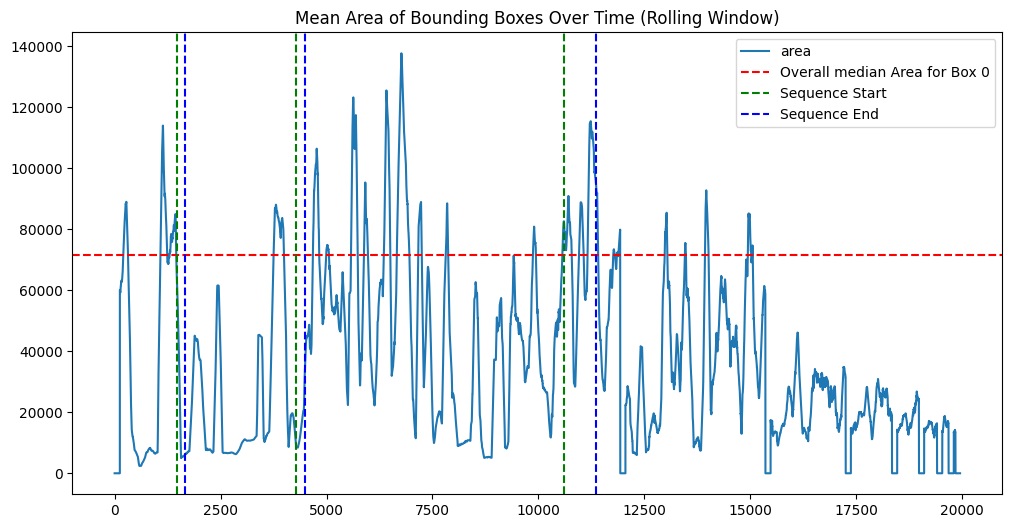

In [28]:
mean_area_rolling_window = (
    video_bounding_boxes
        .groupby("box_idx")
        .rolling(window=125, on="frame_idx")['area']
        .mean()
        .reset_index()          # bring frame_idx back as a column
)

# The first 'window_size - 1' frames will have NaN values for the rolling mean
mean_area_rolling_window.fillna(0, inplace=True)

ax = mean_area_rolling_window.area.plot(figsize=(12, 6), title="Mean Area of Bounding Boxes Over Time (Rolling Window)")

ax.axhline(y=sequence_total_df[sequence_total_df["box_idx"] == 0].area.median(), color='r', linestyle='--', label='Overall median Area for Box 0')
#ax.axhline(y=sequence_total_df.area.mean(), color='m', linestyle='--', label='Overall Mean Area for all boxes')

# Draw sequences start and end lines
for i, (start, end) in enumerate(sequence_frame_indices):
    ax.axvline(x=start, color='g', linestyle='--', label=f'Sequence Start' if i == 0 else "")
    ax.axvline(x=end, color='b', linestyle='--', label=f'Sequence End' if i == 0 else "")

ax.legend()

When looking at the area inside highlight sequences, there is no easy way to discriminate them from other moments in the video.

This solution might be supplementary from the highlight sequence detection, especially to capture long moments where a single person is taking much space in the frame (see frames 5000 to 7500).